In [1]:
import os
#os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"


import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())

# Get detailed device information
print(device_lib.list_local_devices())



set_size=400

shape = (set_size, 128, 128, 98)
dataset = np.random.uniform(low=-1, high=1, size=shape).astype(np.float16)
shape = (set_size)
truth_temp = np.random.uniform(low=0, high=48, size=shape).astype(int)

truth = np.zeros((len(truth_temp), 49), dtype=int)
truth[np.arange(len(truth_temp)), truth_temp] = 1
# Model creation
def create_model(input_shape=(128, 128, 98), num_classes=49):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    logits = Dense(num_classes, activation=None)(x)  # Output 49 logits
    model = Model(inputs=base_model.input, outputs=logits)
    return model

# Loss function for ordinal regression
#@tf.keras.saving.register_keras_serializable(package="Custom")
def ordinal_loss(y_true, y_pred):
    l2_loss = tf.reduce_mean(tf.square(y_pred - y_true), axis=None)
    return l2_loss


# Create model
model = create_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.999),
    loss=ordinal_loss
)

# Training
batch_size = 20
global_steps = 100
steps_per_epoch = set_size // batch_size  # Example for small data, adjust for large datasets
epochs = global_steps // steps_per_epoch

model.fit(dataset, truth, batch_size=batch_size, epochs=epochs)

model.save('/mnt/Velocity_Vault/Autofocus/Model/Tes_Model.keras')  # Save in SavedModel format


from tensorflow.keras.models import load_model

loaded_model = load_model('/mnt/Velocity_Vault/Autofocus/Model/Tes_Model.keras',custom_objects={'ordinal_loss': ordinal_loss})  # Load a SavedModel

# Demo Test
test_dataset = dataset[:50]  # Example test set
predictions = loaded_model.predict(test_dataset)
np.save('/mnt/Velocity_Vault/Autofocus/Model/'+"test_pred.npy",predictions)
# Display predictions
print("Test Predictions (logits):", predictions)


2025-01-15 14:05:23.269208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 14:05:23.280043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736930123.292173  123955 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736930123.295510  123955 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 14:05:23.307707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


I0000 00:00:1736930127.152013  123955 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3419 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1736930127.157990  123955 gpu_device.cc:2022] Created device /device:GPU:0 with 3419 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1736930127.162719  123955 gpu_device.cc:2022] Created device /device:GPU:0 with 3419 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


GPU Available: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8847740999819313437
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3585127219
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1578941526962173651
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


/mnt/Installation/Virtual_Environment/Python3_12/lib/python3.12/site-packages/keras/src/applications/mobilenet_v2.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 98 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
I0000 00:00:1736930131.284301  123955 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3419 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/5


I0000 00:00:1736930145.863011  124276 service.cc:148] XLA service 0x7fd06c0028d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736930145.863040  124276 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-01-15 14:05:46.234795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736930147.543156  124276 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-15 14:05:48.555344: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7934', 324 bytes spill stores, 324 bytes spill loads

2025-01-15 14:05:48.591664: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64

 3/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2835

I0000 00:00:1736930162.954067  124276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 0.1310
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0332
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0264
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0230
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0202


2025-01-15 14:06:11.999355: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 4 bytes spill stores, 4 bytes spill loads

2025-01-15 14:06:12.037814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 324 bytes spill stores, 320 bytes spill loads

2025-01-15 14:06:12.134782: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 400 bytes spill stores, 400 bytes spill loads

2025-01-15 14:06:12.189371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 4180 bytes spill stores, 4052 bytes spill loads



1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step

2025-01-15 14:06:18.011488: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 468 bytes spill stores, 312 bytes spill loads

2025-01-15 14:06:18.154341: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 640 bytes spill stores, 584 bytes spill loads

2025-01-15 14:06:18.190464: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 484 bytes spill stores, 572 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
Test Predictions (logits): [[-0.00187262  0.01203487  0.01828008 ... -0.00995743  0.00269364
  -0.01462701]
 [-0.00187262  0.01203487  0.01828008 ... -0.00995743  0.00269364
  -0.01462701]
 [-0.00187262  0.01203487  0.01828008 ... -0.00995743  0.00269364
  -0.01462701]
 ...
 [-0.00187262  0.01203487  0.01828007 ... -0.00995742  0.00269364
  -0.01462701]
 [-0.00187262  0.01203487  0.01828007 ... -0.00995742  0.00269364
  -0.01462701]
 [-0.00187262  0.01203487  0.01828007 ... -0.00995742  0.00269364
  -0.01462701]]


In [2]:
# print(truth.shape)
# import numpy as np
# predictions=np.load('/mnt/Velocity_Vault/Autofocus/Model/'+"test_pred.npy")

print(type(predictions))
from pprint import pprint
pprint(predictions)

<class 'numpy.ndarray'>
array([[-0.00187262,  0.01203487,  0.01828008, ..., -0.00995743,
         0.00269364, -0.01462701],
       [-0.00187262,  0.01203487,  0.01828008, ..., -0.00995743,
         0.00269364, -0.01462701],
       [-0.00187262,  0.01203487,  0.01828008, ..., -0.00995743,
         0.00269364, -0.01462701],
       ...,
       [-0.00187262,  0.01203487,  0.01828007, ..., -0.00995742,
         0.00269364, -0.01462701],
       [-0.00187262,  0.01203487,  0.01828007, ..., -0.00995742,
         0.00269364, -0.01462701],
       [-0.00187262,  0.01203487,  0.01828007, ..., -0.00995742,
         0.00269364, -0.01462701]], dtype=float32)


In [3]:
pred=predictions[0]

print(pred)

[-1.87261985e-03  1.20348688e-02  1.82800759e-02 -1.71080488e-03
  4.81329020e-03 -1.55273043e-02  8.95741023e-03 -4.91874060e-03
  7.23347999e-03  1.35772862e-05  2.61146808e-03  5.14688995e-03
 -6.74053794e-04 -2.18461081e-02 -1.83329582e-02  1.34492675e-02
  2.93855323e-03 -1.87477637e-02 -1.77828828e-04  1.38143571e-02
  6.90937601e-03 -1.00258260e-03 -4.23923880e-03 -1.52909791e-03
 -1.30301602e-02  6.54090289e-03  4.75955196e-03 -3.04833194e-03
  1.55574353e-02  3.20063205e-03 -6.66503888e-03  5.95083646e-03
 -8.13772809e-03 -2.37888321e-02  1.14902128e-02  9.68061294e-03
  3.26544885e-03  5.07601956e-03 -1.29324347e-02  2.26836428e-02
  7.05683185e-03  3.84963714e-02 -8.24753568e-03  2.74286489e-03
  1.58255734e-02 -1.75210126e-02 -9.95742623e-03  2.69363984e-03
 -1.46270078e-02]


In [8]:
import numpy as np
from pprint import pprint

def calculate_p(x_list):
    return 1 / (1 + np.exp(-x_list))

prob=calculate_p(predictions)

#print("x values:", pred)
pprint((prob.shape))


(50, 49)


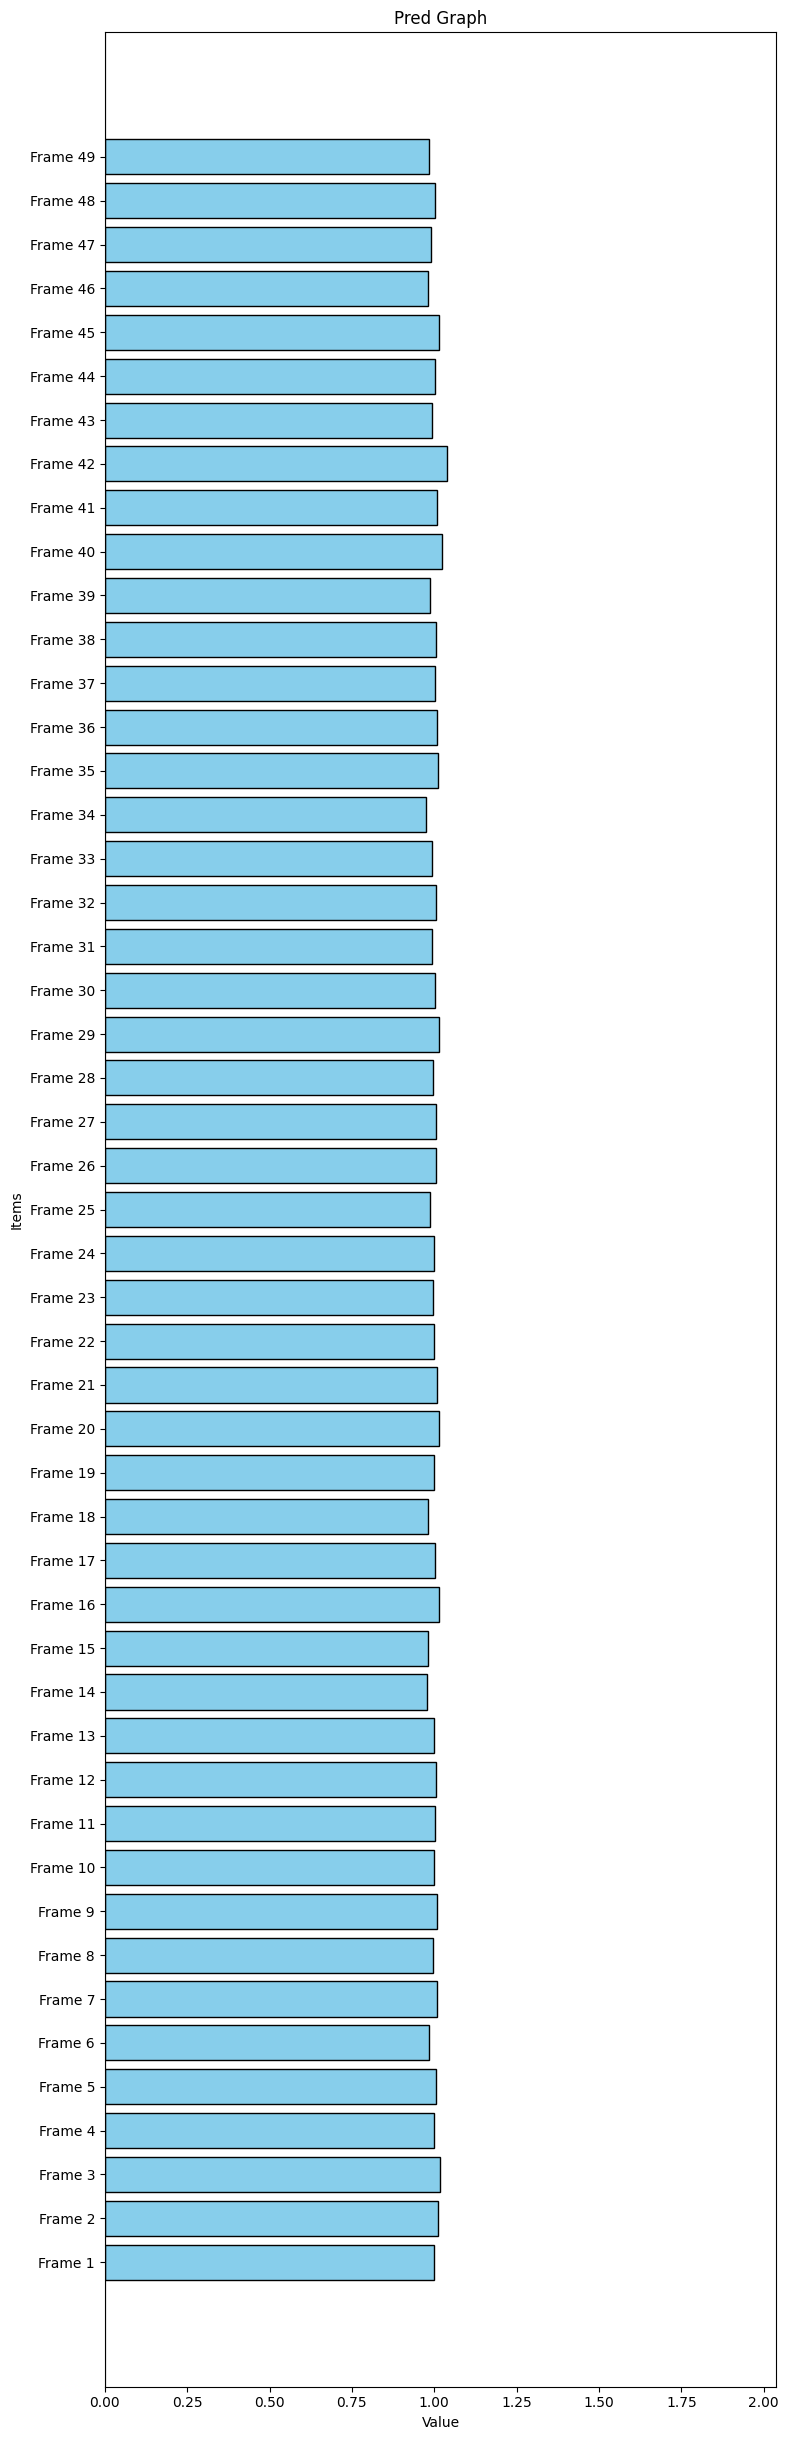

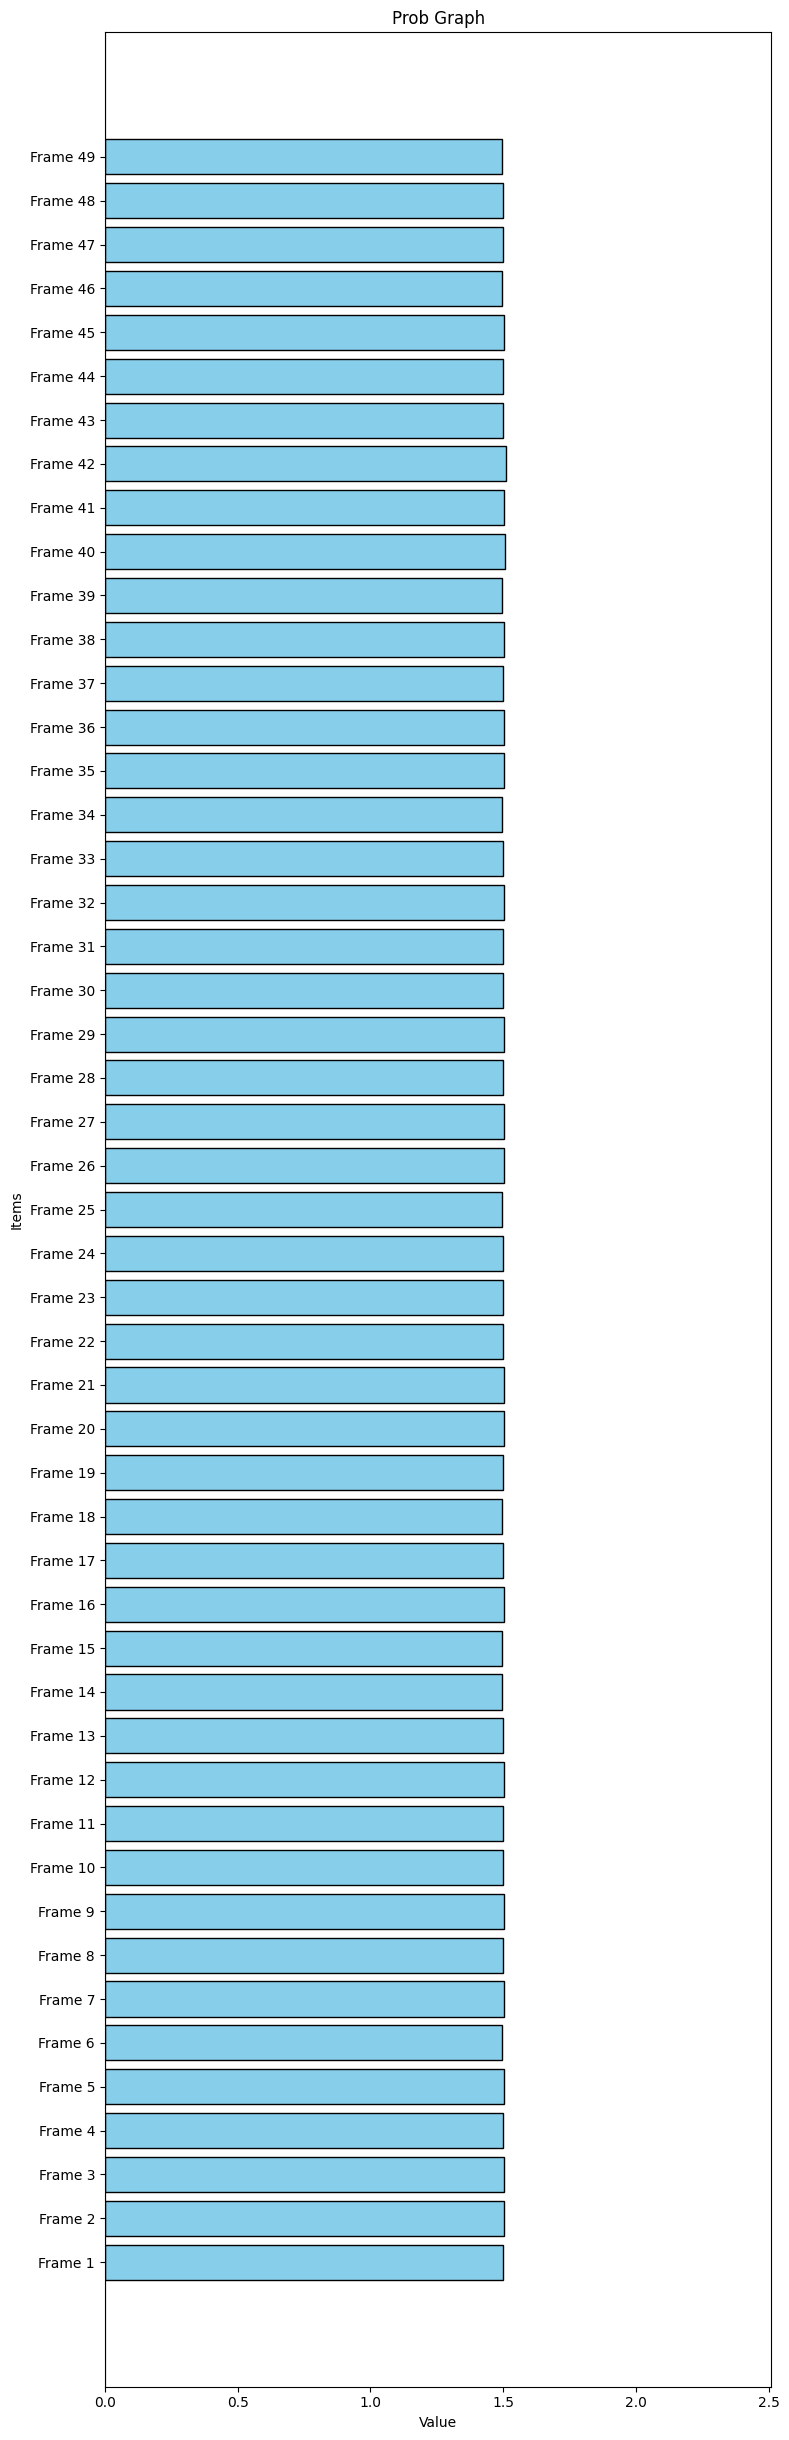

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_horizontal_bar(data, labels=None, title="Horizontal Bar Graph"):
    
    data=[d+1 for d in data]

    if labels is None:
        labels = [f"Frame {i+1}" for i in range(len(data))]
    
    y_positions = np.arange(len(data))
    
    plt.figure(figsize=(8, len(data) * 0.5))  # Adjust figure size based on the number of items
    plt.barh(y_positions, data, color="skyblue", edgecolor="black")
    
    plt.yticks(y_positions, labels)
    plt.xlim(0, max(data) + 1)  # Start x-axis at -1 and end a bit beyond the largest data value
    plt.axvline(0, color="black", linewidth=0.8)  # Add a vertical line at x=0 for reference
    plt.xlabel("Value")
    plt.ylabel("Items")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example Usage
data = [0.2, 0.5, -0.3, 1.0, -0.8]
labels = ["A", "B", "C", "D", "E"]
plot_horizontal_bar(pred, title="Pred Graph")
plot_horizontal_bar(prob, title="Prob Graph")